# 加载图像数据

到目前为止，我们一直使用的都是虚拟数据集。但在实际运用里，你会处理一些完整尺寸的图像，例如智能手机摄像头拍摄的图像。现在，我们将学习如何加载图像并使用它们训练神经网络。

我们将使用[猫狗照片数据集](https://www.kaggle.com/c/dogs-vs-cats)（从 Kaggle 上可以获得）。下面是几个示例图像：

<img src='assets/dog_cat.png'>

我们将使用该数据集训练神经网络区分猫和狗。五年前，这对于计算机视觉系统来说，是一项巨大的挑战。现在，它的应用就很普遍了。

In [25]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms

import helper

加载图像的最简单方式是使用 `torchvision` 的 `datasets.ImageFolder`（[文档](http://pytorch.org/docs/master/torchvision/datasets.html#imagefolder)）。使用 `ImageFolder`，就是这样：

dataset = datasets.ImageFolder('path/to/data', transform=transform)

其中 `'path/to/data'` 是通往数据目录的文件路径，`transform` 是用 `torchvision` 中的 [`transforms`](http://pytorch.org/docs/master/torchvision/transforms.html) 模块构建的处理步骤列表。ImageFolder 中的文件和目录应按以下格式构建：

root/dog/xxx.png

root/dog/xxy.png

root/dog/xxz.png

root/cat/123.png

root/cat/nsdf3.png

root/cat/asd932_.png

每个图像类别都有各自存储图像的目录（`cat` 和 `dog`）。然后使用从目录名中提取的类别标记图像。图像 `123.png` 将采用类别标签 `cat`。你可以从[此页面](https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip)下载已经采用此结构的数据集。我还将其拆分成了训练集和测试集。

### 转换

使用 `ImageFolder` 加载数据时，你需要定义转换。例如，图像的尺寸不相同，但是我们需要将它们变成统一尺寸，才能用于训练模型。你可以使用 `transforms.Resize()` 调整尺寸或使用 `transforms.CenterCrop()`、`transforms.RandomResizedCrop()` 等裁剪图像。我们还需要使用 `transforms.ToTensor()` 将图像转换为 PyTorch 张量。通常，你将使用 `transforms.Compose()`来将这些转换结合到一条流水线中，这条流水线接收包含转换的列表，并按顺序运行。流程大概为缩放、裁剪，然后转换为张量：

transform = transforms.Compose([transforms.Resize(255),

                    transforms.CenterCrop(224),             
                    
                    transforms.ToTensor()])


我们可以使用许多种转换，接下来我会逐步讲解，你也可以查看这里的[文档](http://pytorch.org/docs/master/torchvision/transforms.html)。 

### 数据加载器

加载 `ImageFolder` 后，你需要将其传入 [`DataLoader`](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader)。`DataLoader` 接受数据集（例如要从 `ImageFolder` 获得的数据集），并返回批次图像和相应的标签。你可以设置各种参数，例如批次大小，或者在每个周期之后是否重排数据。

In [27]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

`dataloader` 是一个[生成器](https://jeffknupp.com/blog/2013/04/07/improve-your-python-yield-and-generators-explained/)。要从中获取数据，你需要遍历它，或将它转换成迭代器并调用 `next()`。

In [ ]:
# Looping through it, get a batch on each loop 
for images, labels in dataloader:
    pass

# Get one batch
images, labels = next(iter(dataloader))

>**练习：**请从 `Cat_Dog_data/train` 文件夹加载图像，定义几个转换，然后构建数据加载器。

In [29]:
data_dir = 'Cat_Dog_data/train'

#TODO: compose transforms here
transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()])
# TODO: create the ImageFolder
dataset = datasets.ImageFolder(data_dir, transform=transform)
# TODO: use the ImageFolder dataset to create the DataLoader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

In [30]:
# Run this to test your data loader
images, labels = next(iter(dataloader))
print(labels[0])

tensor(0)


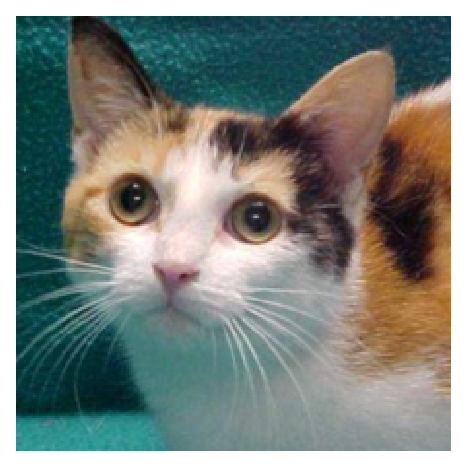

In [31]:
helper.imshow(images[0], normalize=False)

如果数据加载正确，你应该看到类似如下所示的结果：

<img src='assets/cat_cropped.png' width=244>

## 数据增强

训练神经网络的一个常见策略是在输入数据本身里引入随机性。例如，你可以在训练过程中随机地旋转、翻转、缩放和/或裁剪图像。这样一来，你的神经网络在处理位置、大小、方向不同的相同图像时，可以更好地进行泛化。

要随机旋转、缩放、裁剪图像，然后翻转图像，你需要如下所示地定义转换：

In [32]:
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5], 
                                                            [0.5, 0.5, 0.5])])

另外，还需要使用 `transforms.Normalize` 标准化图像。传入均值和标准偏差列表，然后标准化颜色通道


减去 `mean` 使数据以 0 居中，除以 `std` 使值位于 -1 到 1 之间。准化有助于神经网络使权重接近 0，这能使反向传播更为稳定。不标准化的话，网络往往会学习失败。

你可以在[此处查看可用的转换列表](http://pytorch.org/docs/0.3.0/torchvision/transforms.html)。测试时，不能改变图像（但是需要以同一方式标准化）。因此，在验证/测试图像时，通常只能调整大小和裁剪图像。

>**练习：**请为下面的训练数据和测试数据定义转换。

In [33]:
data_dir = 'Cat_Dog_data'

# TODO: Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor()]) 

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor()])


# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=32)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32)

In [34]:
# change this to the trainloader or testloader 
data_iter = iter(testloader)

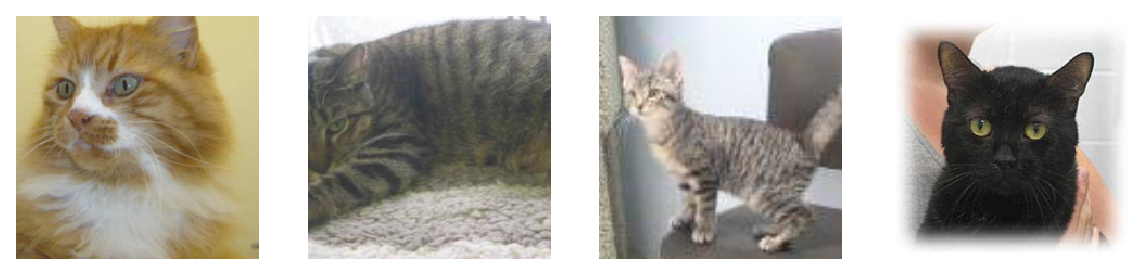

In [35]:
images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    helper.imshow(images[ii], ax=ax, normalize=False)

转换后的图像应该如下所示。

<center>训练示例：</center>
<img src='assets/train_examples.png' width=500px>

<center>测试示例：</center>
<img src='assets/test_examples.png' width=500px>

好了，我们学习了加载训练和测试数据。现在，试试构建网络来分类猫和狗。这个题目其实挺难的，但不用担心，先试试！不过，说实话，使用完全连接的网络很有可能不可行。这些图像有三个颜色通道，而且分辨率更高（而我们之前试过的只是分辨率很小的 28x28 图像）。

在下个部分，我将演示如何使用预训练网络构建能实际解决该问题的模型。


```python
# Optional TODO: Attempt to build a network to classify cats vs dogs from this dataset
```